## Bayesian Neural Networks in PyMC3

In [ ]:
# default_exp bayesian_deep_learning

In [ ]:
%matplotlib inline
import theano
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt

from warnings import filterwarnings
filterwarnings('ignore')
sns.set_style('white')

import sklearn
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

### Generating data

In [ ]:
X, Y = make_moons(n_samples=1000, noise=0.2, random_state=0)
X = scale(X)
X = X.astype(float)
Y = Y.astype(float)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)

In [ ]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((500, 2), (500,), (500, 2), (500,))

In [ ]:
X[Y==0, 0].shape

(500,)

[Text(0.5, 0, 'X'),
 Text(0, 0.5, 'Y'),
 Text(0.5, 1.0, 'Toy binary classification dataset')]

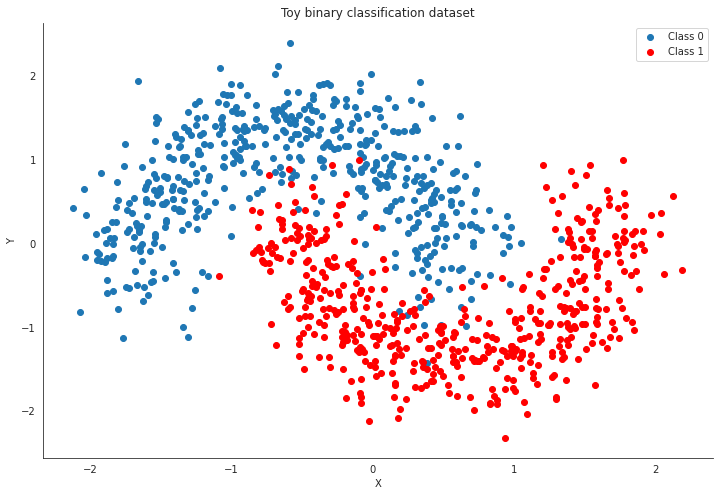

In [ ]:
# Plot data
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], label='Class 1', color='r')
sns.despine()
ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification dataset')

### Model specification
Here we will use 2 hidden layers with 5 neurons

In [ ]:
def construct_nn(ann_input, ann_output):
    n_hidden = 5
    
    # Initialize random weights between each layer
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(float)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(float)
    init_out = np.random.randn(n_hidden).astype(float)
    
    with pm.Model() as neural_network:
        # Weights from input to hidden layers
        weights_in_1 = pm.Normal('w_in_1', 0, sd=1,
                                 shape=(X.shape[1], n_hidden),
                                 testval=init_1)
        weights_1_2 = pm.Normal('w_1_2', 0, sd=1,
                                shape=(n_hidden, n_hidden),
                                testval=init_2)
        weights_2_out = pm.Normal('w_2_out', 0, sd=1,
                                  shape=(n_hidden,),
                                  testval=init_out)
        
        # Build neural-network using tanh activation
        act_1 = pm.math.tanh(pm.math.dot(ann_input, weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2, weights_2_out))
        
        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out', act_out, observed=ann_output,
                           total_size=Y_train.shape[0]) # Important for minibatches
    return neural_network
        

In [ ]:
%%time
ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)
neural_network = construct_nn(ann_input, ann_output)

CPU times: user 283 ms, sys: 60.9 ms, total: 344 ms
Wall time: 4.81 s


### Variational Inference: Scaling model complexity

In [ ]:
# !pip uninstall theano-pymc  # run a few times until it says not installed
# !pip install "pymc3<3.10" "theano==1.0.5"
# Better using:
# !conda install "pymc3==3.9.0" "theano==1.0.4" "CPython==3.7.7"

In [ ]:
from pymc3.theanof import set_tt_rng, MRG_RandomStreams

set_tt_rng(MRG_RandomStreams(42))

ImportError: cannot import name 'MRG_RandomStreams' from 'pymc3.theanof' (/opt/conda/lib/python3.9/site-packages/pymc3/theanof.py)

In [ ]:
%%time

with neural_network:
    inference = pm.ADVI()
    approx = pm.fit(n=50000, method=inference)


You can find the C code in this temporary file: /tmp/theano_compilation_error_e6dyhula


Exception: ('Compilation failed (return status=1): /home/jovyan/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.31-x86_64-3.9.2-64/tmp98uft2y4/mod.cpp:3:10: fatal error: theano_mod_helper.h: No such file or directory.     3 | #include "theano_mod_helper.h".       |          ^~~~~~~~~~~~~~~~~~~~~. compilation terminated.. ', "FunctionGraph(MakeVector{dtype='float64'}(__logp_w_in_1, __logp_w_1_2, __logp_w_2_out))")